# Get an idea of the data

In [128]:
import requests,base64
import pandas as pd
import os
import base64
import textwrap
import numpy as np
import matplotlib.pyplot as plt

Call the ASR Pipeline

In [74]:
# Replace with your own path
df = pd.read_json('Marina/dfs/deco/Intervention_Decoding_df.json')

In [75]:
#### Convert file to base64 string for sending to the ASR pipeline
def file_to_base64(filepath):    
    if not isinstance(filepath, str):
        print(f"Error: filepath is not a string. Type: {type(filepath)}")
        return None
    if not os.path.exists(filepath):
        print(f"Error: File does not exist at {filepath}")
        return None
    try:
        with open(filepath, 'rb') as file:
            file_content = file.read()
        base64_encoded = base64.b64encode(file_content).decode('ASCII')        
        return base64_encoded
    except Exception as e:
        print(f"Error in file_to_base64: {str(e)}")
    return None

#### Function to call the ASR pipeline
def call_asr_pipeline_( service_address, 
                          audio_file_path,
                          reference_text,
                        ):
    audio_file_base64_string = file_to_base64(audio_file_path)
    payload = {
        "audio": audio_file_base64_string,
        "reference_text": reference_text,
    }
    response = requests.post( service_address,
                              json = payload,
                              headers = {"Content-Type": "application/json"}
                            )
    return response.json()


def call_asr_pipeline( service_address, 
                          audio_file_path,
                          reference_text,
                          target_duration_segment,
                            min_duration_segment,
                            threshold_diff,
                            max_pred_per_word,
                        ):
    audio_file_base64_string = file_to_base64(audio_file_path)
    payload = {
        "audio": audio_file_base64_string,
        "reference_text": reference_text,
        "target_duration_segment": target_duration_segment,
        "min_duration_segment": min_duration_segment,
        "threshold_diff": threshold_diff,
        "max_pred_per_word": max_pred_per_word,
    }
    response = requests.post( service_address,
                              json = payload,
                              headers = {"Content-Type": "application/json"}
                            )
    
    return response.json()

# example of calling the ASR pipeline
call_asr_pipeline("http://localhost:5000/asr_pipeline", 
                  audio_file_path = "Marina/audio/abricot.wav", 
                  reference_text = "abricot", 
                  target_duration_segment = 4, 
                  min_duration_segment = 2, 
                  threshold_diff = 1.5, 
                  max_pred_per_word = 35
                  k = 10,
                  top_k_is_all = True)

If you want to analyse on your dataset with different values of threshold_diff

In [ ]:
# for each line in the dataframe, call the ASR pipeline and get the results
target_duration_segment = 4
min_duration_segment = 2
threshold_diff = 1.5
max_pred_per_word = 25

for index, row in df.iterrows():
    print(f"Processing index {index}")
    audio_file_path = row['filepath']
    reference_text = row['reference_text']

    # if index is 0 then create the columns for the results for that threshold_diff
    print(f"___Processing threshold_diff {threshold_diff}")
    if index == 0:
        for col in [f'correct_{threshold_diff}', f'results_decode_{threshold_diff}', f'all_decoded_predictions_whole_{threshold_diff}', f'transcriptions_segments_{threshold_diff}', f'correct_match_{threshold_diff}', f'results_decode_match_{threshold_diff}']:
            df[col] = None

    # call the ASR pipeline
    response = call_asr_pipeline("http://localhost:5000/asr_pipeline", audio_file_path, reference_text, target_duration_segment, min_duration_segment, threshold_diff, max_pred_per_word)
    print(f"____Response: {response}")

    # save the results in the dataframe
    df.at[index, f'correct_{threshold_diff}'] = response['correct']
    df.at[index, f'results_decode_{threshold_diff}'] = response['results_decode']
    df.at[index, f'all_decoded_predictions_whole_{threshold_diff}'] = response['all_decoded_predictions_whole']
    df.at[index, f'transcriptions_segments_{threshold_diff}'] = response['transcriptions_segments'],
    df.at[index, f'correct_match_{threshold_diff}'] = response['correct_match']
    df.at[index, f'results_decode_match_{threshold_diff}'] = response['results_decode_match']  

# save the dataframe to a json file (change the path to your own)
df.to_json('Marina/dfs/deco/comparisons.json')

Plots

In [167]:
def plots_all(df_model_comparison, title, mode, asr_acc_column, plot = True):
    
    # Initialize dictionaries to store TP, TN, FP, FN counts for each config_id
    tp_counts = {}
    tn_counts = {}
    fp_counts = {}
    fn_counts = {}
    word_counts = {}

    for idx, row in df_model_comparison.iterrows():
        if mode == 'all':
            config_id = ''
        elif mode == 'config_id':
            config_id = row['reference_text']
        elif mode == 'trial':
            config_id = row['config_id']
        else:
            raise ValueError("Invalid mode. Choose 'all', 'config_id', or 'trial'.")
        
        asr_accuracy = [int(i) for i in row[asr_acc_column]]
        # if accuracy is an integer, convert it to a list of integers
        accuracy = [int(i) for i in row['accuracy'].split(" ") if i.isdigit()]
        
        if len(asr_accuracy) != len(accuracy):
            print("Different lengths of asr_accuracy and accuracy lists")
            continue
        
        # Change all values of 2 to 1 in the accuracy list
        accuracy = [1 if i == 2 else i for i in accuracy]

        # Initialize counts for this config_id if not already done
        if config_id not in tp_counts:
            tp_counts[config_id] = [0] * len(asr_accuracy)
            tn_counts[config_id] = [0] * len(asr_accuracy)
            fp_counts[config_id] = [0] * len(asr_accuracy)
            fn_counts[config_id] = [0] * len(asr_accuracy)
            word_counts[config_id] = [0] * len(asr_accuracy)

        for i in range(len(asr_accuracy)):
            if asr_accuracy[i] == 1 and accuracy[i] == 1:
                tp_counts[config_id][i] += 1
            elif asr_accuracy[i] == 1 and accuracy[i] == 0:
                fp_counts[config_id][i] += 1
            elif asr_accuracy[i] == 0 and accuracy[i] == 1:
                fn_counts[config_id][i] += 1
            elif asr_accuracy[i] == 0 and accuracy[i] == 0:
                tn_counts[config_id][i] += 1
            word_counts[config_id][i] += 1

    # sort the config_ids by name for consistent plotting

    config_ids = ['easy', 'complex', 'pseudo'] if mode == 'trial' else list(tp_counts.keys())

    # Calculate rates
    #config_ids = list(tp_counts.keys())
    tp_rates = [sum(tp_counts[config_id]) / sum(word_counts[config_id]) for config_id in config_ids]
    tn_rates = [sum(tn_counts[config_id]) / sum(word_counts[config_id]) for config_id in config_ids]
    fp_rates = [sum(fp_counts[config_id]) / sum(word_counts[config_id]) for config_id in config_ids]
    fn_rates = [sum(fn_counts[config_id]) / sum(word_counts[config_id]) for config_id in config_ids]

    # Plotting the results
    indices = np.arange(len(config_ids))  # Config ID indices

    if plot:
        plt.figure(figsize=(12.5, 6))

        # Stacked bar plot
        plt.bar(indices, tp_rates, label='TP Rate', color='green', bottom=np.add(tn_rates, np.add(fp_rates, fn_rates)))
        plt.bar(indices, tn_rates, label='TN Rate', color='blue', bottom=np.add(fp_rates, fn_rates))
        plt.bar(indices, fp_rates, label='FP Rate', color='red', bottom=fn_rates)
        plt.bar(indices, fn_rates, label='FN Rate', color='orange')

        plt.xticks(indices, config_ids, rotation=90)  
        plt.ylabel('Rate')
        plt.title('TP, TN, FP, FN Rates per Config ID')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        plt.yticks(np.arange(0, 1.1, 0.1))
        plt.axhline(y=0.5, color='black', linestyle='-', linewidth=1)
        plt.title(title)
        plt.grid(axis='y', linestyle='--', alpha=0.5, color='black')
        plt.show()

    # Print TP, TN, FP, FN rates for each config_id (rounded to 1 decimal)
    #for config_id, tp, tn, fp, fn in zip(config_ids, tp_rates, tn_rates, fp_rates, fn_rates):
     #   print(f'{config_id}: TP = {tp:.2f}, TN = {tn:.2f}, FP = {fp:.2f}, FN = {fn:.2f}')
        # print not rounded
      #  print(f'{config_id}: TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}')

    new_rows = []
    # Print TP, TN, FP, FN rates for each config_id (rounded to 1 decimal)
    for config_id, tp, tn, fp, fn in zip(config_ids, tp_rates, tn_rates, fp_rates, fn_rates):
        #print(f'{config_id}: TP = {tp:.2f}, TN = {tn:.2f}, FP = {fp:.2f}, FN = {fn:.2f}')
        
        # Create a dictionary for the new row
        new_row = {
            'config_id': config_id,
            'model': title,
            f'fn': fn,
            f'fp': fp,
            f'tn': tn,
            f'tp': tp
        }
    
        new_rows.append(new_row)

    new_rows_df = pd.DataFrame(new_rows)

    return new_rows_df


In [155]:
def create_stacked_accuracy_plots(df, mode = 'all'):
    configs = ['easy', 'complex', 'pseudo'] if mode == 'trial' else ['']
    metrics = ['fn', 'fp', 'tn', 'tp']  # Order matters for stacking
    colors = ['orange', 'red', 'blue', 'green']
    
    # Unique models in the DataFrame
    models = df['model'].unique()
    
    # Wrap model names if they are too long
    wrapped_models = [textwrap.fill(model, width=15) for model in models]
    
    # Loop over each configuration
    for config in configs:
        fig, ax = plt.subplots(figsize=(18, 7.5))
        
        # X-axis values are the models
        x = np.arange(len(models))
        bottom = np.zeros(len(models))

        # Loop over each metric to create stacked bars
        for metric, color in zip(metrics, colors):
            # Extract values for each metric and configuration
            values = df[df['config_id'] == config][metric].values
            ax.bar(x, values, bottom=bottom, label=f'{metric.upper()} Rate', color=color)
            bottom += values
        
        # Add TP + TN percentages on top of each bar and FP percentage
        for i, model in enumerate(models):
            if mode == 'trial':  
                tp_value = df[(df['model'] == model) & (df['config_id'] == config)]['tp'].values[0]
                tn_value = df[(df['model'] == model) & (df['config_id'] == config)]['tn'].values[0]
                fp_value = df[(df['model'] == model) & (df['config_id'] == config)]['fp'].values[0]
            elif mode == 'all':
                tp_value = df[df['model'] == model]['tp'].values[0]
                tn_value = df[df['model'] == model]['tn'].values[0]
                fp_value = df[df['model'] == model]['fp'].values[0]
            
            tp_tn_sum = tp_value + tn_value
            
            # TP + TN text with bold and underline
            tp_tn_text = f"{tp_tn_sum:.0%}"
            # FP text with red color
            fp_text = f"{fp_value:.0%}"
            
            # Combine the two text elements and position them
            ax.text(i,  -0.2, 
                    f" {tp_tn_text}\n{fp_text}",
                    ha='center', va='bottom', fontsize=12,
                    color='red' if metric == 'fn' else 'black')
        
        ax.set_ylabel('Rate')
        ax.set_title(f'{config.capitalize()} Configuration', fontsize = 12)
        # bold title
        ax.title.set_fontweight('bold')
        ax.set_xticks(x)
        ax.set_xticklabels(wrapped_models, rotation=0, ha='center', fontsize = 12, fontweight = 'bold')  # Horizontal text
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_ylim(0, 1)  # Increased to make room for percentage labels
        ax.set_yticks(np.arange(0, 1.1, 0.1))
        ax.grid(axis='y', linestyle='--', alpha=1, color='black')
        # y axis grid line on top of the bars
        #ax.set_axisbelow(False)
        # x grid line not needed
        ax.xaxis.grid(False)
        
        # Add a horizontal line at y=0.5
        ax.axhline(y=0.5, color='black', linestyle='-', linewidth=1)
        #make this line on top of the bars
        ax.set_zorder(1)
        ax.patch.set_visible(False)
        
        plt.tight_layout()
        plt.show()




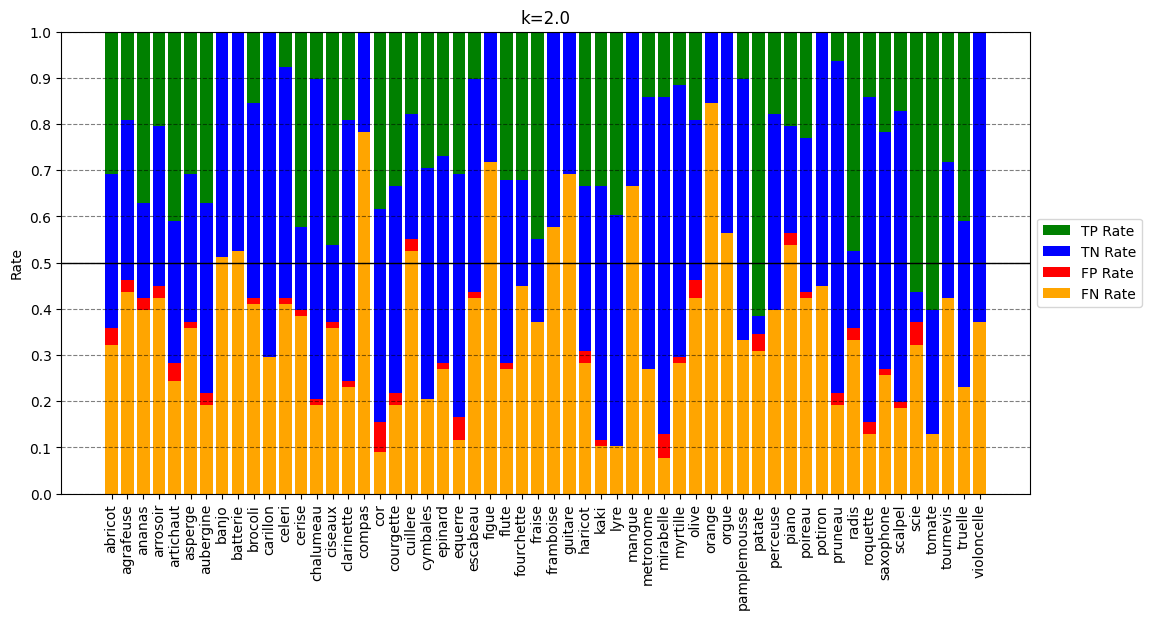

In [168]:
for mode in ['config_id']:
    all_rows = []
    for threshold_diff in [2.0]:
        # convertt col f'correct_{threshold_diff}' from list of int to string of int
        df[f'correct_{threshold_diff}'] = df[f'correct_{threshold_diff}'].apply(lambda x: ' '.join([str(i) for i in x]))
        df_curr = plots_all(df, f'k={threshold_diff}', mode, f'correct_{threshold_diff}')
        all_rows.append(df_curr)
    df_plots_trial_rem = pd.concat(all_rows, ignore_index=True)    

In [176]:
# Results for each model
for index, row in df.iterrows():
    print(f"Index: {index}")
    print(f"Reference text: {row['reference_text']}")
    print(f"Accuracy Professional: {row['accuracy']}")
    print(f"Accuracy ASR: {row['correct_2.0']}")
    print(f"All decoded predictions whole 2.0: {row['all_decoded_predictions_whole_2.0']}")
    print("\n")

Index: 0
Reference text: abricot
Accuracy Professional: 1
Accuracy ASR: 1
All decoded predictions whole 2.0: [['œ̃', 'ã', 'a', 'œ'], ['bʁiko']]


Index: 1
Reference text: agrafeuse
Accuracy Professional: 1
Accuracy ASR: 1
All decoded predictions whole 2.0: [['œn', 'ɔ̃n', 'ỹn', 'œ̃n', 'yn', 'ɔn'], ['n ɛɡʁaføz', 'n ɛɡʁafyz', 'ɛɡʁaføz', 'ɛɡʁafyz', 'aɡʁaføz', 'n aɡʁaføz', 'aɡʁafyz', 'n aɡʁafyz'], ['mɛ'], ['ʒə', 'ʒe'], ['pøz', 'pø'], ['apyije'], ['si'], ['vvu', 'vuu', 'vuvu', 'vu'], ['vule', 'vulez']]


Index: 2
Reference text: ananas
Accuracy Professional: 1
Accuracy ASR: 1
All decoded predictions whole 2.0: [['ɑnama', 'ãana', '̃nama', 'aama', 'nana', 'ɑ̃ama', 'aɑ̃nama', 'ɑnana', 'ɑama', 'aɑama', 'aɑ̃ama', 'ana', 'aana', 'aɑana', 'aɑ̃ana', '̃nana', 'aɑnama', 'nama', 'ɑ̃nana', 'ɑ̃nama', '̃ana', 'aɑ̃nana', 'ama', 'ãnama', 'anana', 'ɑ̃ana', 'ɑana', '̃ama', 'ãama', 'anama', 'ãnana', 'aɑnana']]


Index: 3
Reference text: arrosoir
Accuracy Professional: 1
Accuracy ASR: 0
All decoded predic

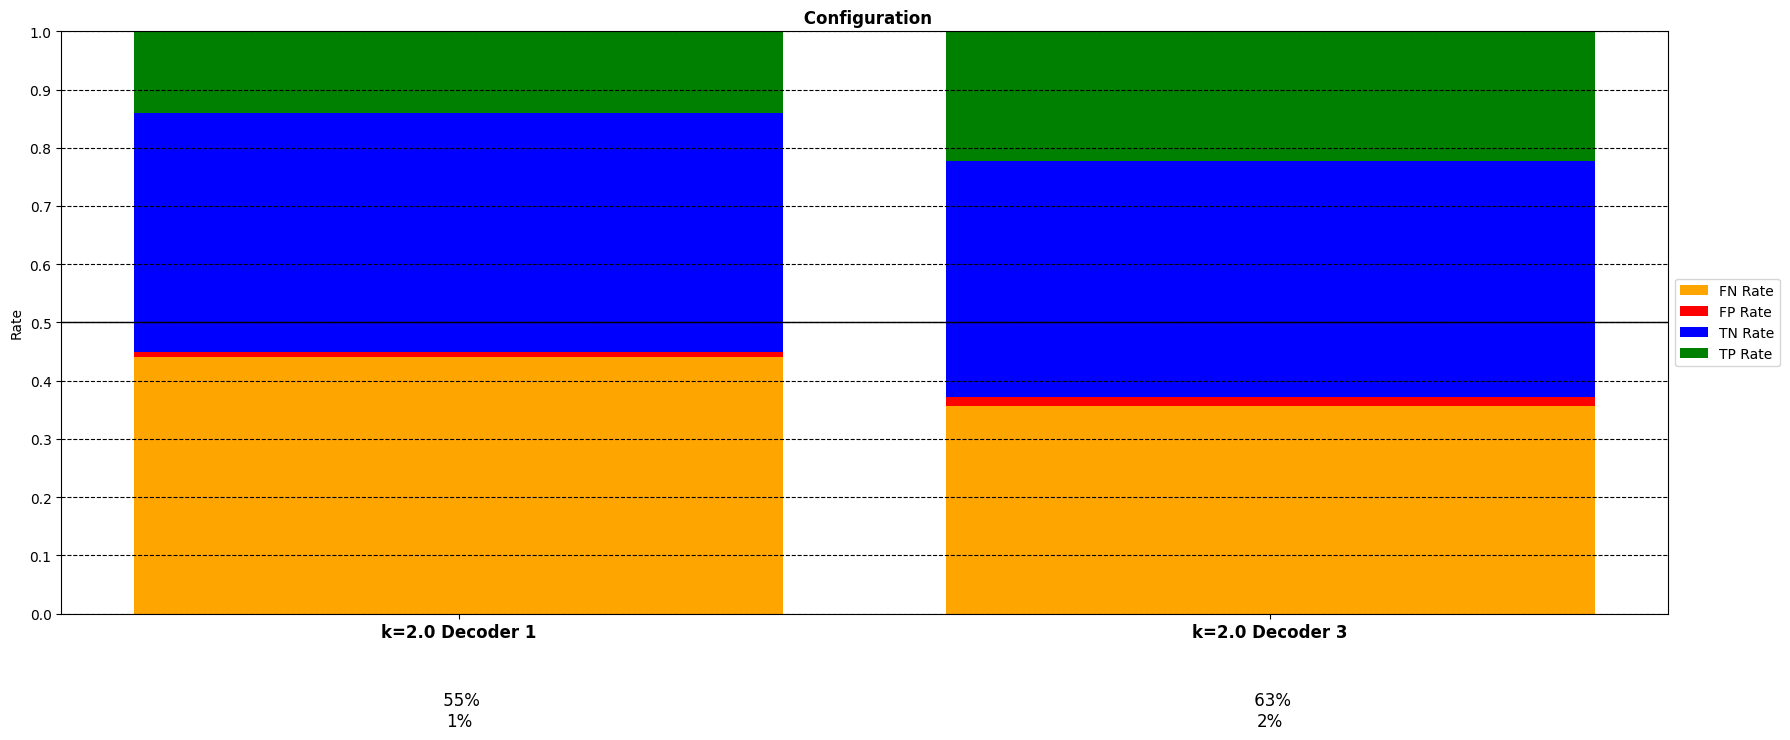

In [172]:
for mode in ['all']:
    all_rows = []

    for threshold_diff in [2.0]: # can plot results for different parameters

        df_curr =  plots_all(df, f'k={threshold_diff} Decoder 1', mode, f'correct_match_{threshold_diff}', plot = False)
        all_rows.append(df_curr)
        df_curr = plots_all(df, f'k={threshold_diff} Decoder 3', mode, f'correct_{threshold_diff}', plot = False)
        all_rows.append(df_curr)

    df_plots_trial_rem = pd.concat(all_rows, ignore_index=True) 

create_stacked_accuracy_plots(df_plots_trial_rem, mode = 'all')  